# Two new greedy algorithms: the data based algorithm and the projection pursuit


We have a solution $u$ (actually $u_h$, i.e. the solution of FEM here, but lets just assume it is ground truth here). 
We're given our measurement basis $W_m = \mathrm{span}\{w_1,\ldots,w_m\}$. I make it orthonormal for the purpose of this computation (NB it's worth trying without orthonormality). We have a series of measurements $\langle w_i, u\rangle_V$, and we write $w = P_{W_m} u$, the projection of $u$ in $W_m$.

Consider a dictionary $\mathcal{D}$, which is complete in our solution space $V$ (here equal to $H_0^1$). Evidently we have to consider a finite dictionary, with $N$ samples, which we label $\mathcal{D}_N$.  We search through this finite dictionary for our elements $\phi_i$ of the basis $V_n$, by doing a greedy search for $\phi_n$ given $V_{n-1}$, for some criteria specified below.

### Algorithm 1: measurement driven greedy basis construction

In this algorithm the first member is chosen as
$$
\phi_1 = \mathrm{argmax}_{\phi\in\mathcal{D_N}} \left\langle w, \frac{P_{W_m} \phi}{\|P_{W_m} \phi\|} \right\rangle_V
$$
and the $n$-th member is
$$
\phi_n = \mathrm{argmax}_{\phi\in\mathcal{D_N}} \left\langle w - P_{V_{n-1}} w, \frac{P_{W_m} \phi}{\| P_{W_m} \phi \| } \right\rangle_V
$$
The way this is coded is more or less as written above. Note that this method is fast as at each step we only have to compute $w-P_{V_{n-1}}w$ once, and this is only an $n-1$ system to solve.

### Algorithm 2: projection pursuit greedy basis construction

In this algorithm, we chose
$$
\phi_1 = \mathrm{argmax}_{\phi\in\mathcal{D_N}} \left\langle w, \frac{\phi}{\|\phi\|} \right\rangle_V
$$
and the $n$-th member is
$$
\phi_n = \mathrm{argmax}_{\phi\in\mathcal{D_N}} \left\langle w , \frac{\phi - P_{V_{n-1}} \phi}{\| \phi - P_{V_{n-1}} \phi \| } \right\rangle_V
$$

### Removal property - these algorithms do not rule out $v$ if $v\in V_n$
In the plain algorithm we have, quite evidently, that the $\mathrm{argmax}$ step ignores anything in $V_n$ as the perpindicular is $0$. Here however we have no such guarantee, so we must remove elements from the dictionary as we construct the basis. What does this mean? What about if there are two $v_0$ and $v_1$ that are very close to each other in the dictionary and one gets chosen for the greedy basis...?

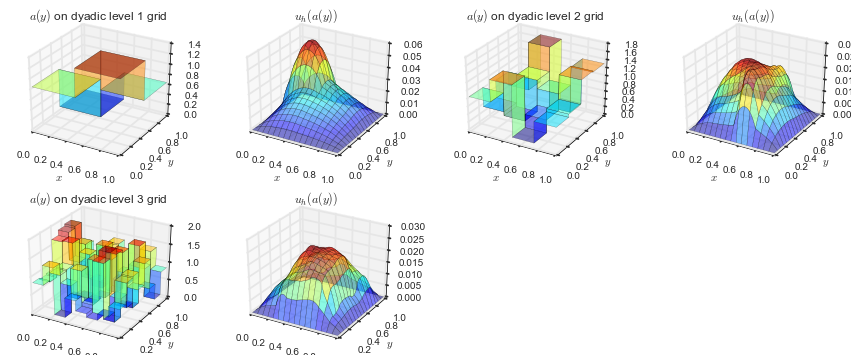

In [1]:
import numpy as np
import importlib
import dyadic_fem as df
import point_generator as pg
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
importlib.reload(df)
importlib.reload(pg)
%matplotlib inline

fem_div = 7

a_bar = 1.0
c = 0.9

np.random.seed(1)
y_4 = 2 * np.random.random(2**1 * 2**1) - 1
a_4 = df.DyadicPWConstant(a_bar + c * y_4.reshape([2**1, 2**1]), div=1)
fem_4 = df.DyadicFEMSolver(div=fem_div, rand_field=a_4, f=1.0)
fem_4.solve()

np.random.seed(1)
y_16 = 2 * np.random.random(2**2 * 2**2) - 1
a_16 = df.DyadicPWConstant(a_bar + c * y_16.reshape([2**2, 2**2]), div=2)
fem_16 = df.DyadicFEMSolver(div=fem_div, rand_field=a_16, f=1.0)
fem_16.solve()

np.random.seed(1)
y_64 = 2 * np.random.random(2**3 * 2**3) - 1
a_64 = df.DyadicPWConstant(a_bar + c * y_64.reshape([2**3, 2**3]), div=3)
fem_64 = df.DyadicFEMSolver(div=fem_div, rand_field=a_64, f=1.0)
fem_64.solve()

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(2, 4, 1, projection='3d')
a_4.plot(ax, title='$a(y)$ on dyadic level 1 grid')
ax = fig.add_subplot(2, 4, 2, projection='3d')
fem_4.u.plot(ax, title='$u_h(a(y))$')
ax = fig.add_subplot(2, 4, 3, projection='3d')
a_16.plot(ax, title='$a(y)$ on dyadic level 2 grid')
ax = fig.add_subplot(2, 4, 4, projection='3d')
fem_16.u.plot(ax, title='$u_h(a(y))$')
ax = fig.add_subplot(2, 4, 5, projection='3d')
a_64.plot(ax, title='$a(y)$ on dyadic level 3 grid')
ax = fig.add_subplot(2, 4, 6, projection='3d')
fem_64.u.plot(ax, title='$u_h(a(y))$')
plt.show()

[]

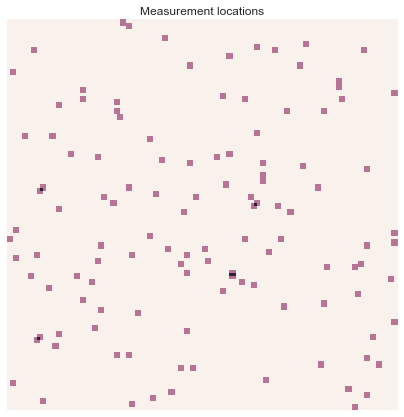

In [2]:
# local_width is the width of the measurement squares
local_width = 2**(fem_div - 6)

m = 120

# We make the ambient spaces for Wm and Vn
np.random.seed(2)

# we make a bounding box to be the quarter square
side_n = 2**fem_div-1
bounding_box = np.array([[0, 2**(fem_div-1)], [0, 2**(fem_div-1)]])

Wm, Wloc = df.make_random_local_integration_basis(m=m, div=fem_div, width=local_width, space='H1', return_map=True)
Wm = Wm.orthonormalise()

fig, ax = plt.subplots(figsize=(7,7))     
sns.heatmap(Wloc.values, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
ax.set_title('Measurement locations')
plt.plot()

### Construct the bases using the greedy algorithms. Caution this takes a *lot* of computational effort. To save the time, load the bases constructed on the cluster and saved in files. This is done in the next lot of cells...

In [ ]:
field_div = 2

# This is the measurement vector
w = Wm.dot(fem_16.u)

point_gen = pg.MonteCarlo(d=2**field_div*2**field_div, n=5000, lims=[-1, 1], seed=3)
point_gen = pg.QMCLatticeRule(d=2**field_div*2**field_div, n=5000, lims=[-1, 1])
 
u_dict, dict_fields = df.make_dictionary(point_gen, fem_div, a_bar=a_bar, c=c, verbose=False)

gr_cons = df.GreedyBasisConstructor(n=m, fem_div=fem_div, dictionary=u_dict, verbose=True)
Vn_gr = gr_cons.construct_basis()

db_cons = df.DBGreedyBasisConstructor(n=m, fem_div=fem_div, Wm=Wm, w=w, dictionary=u_dict, verbose=True)
Vn_db = db_cons.construct_basis()

pp_cons = df.PPGreedyBasisConstructor(n=m, fem_div=fem_div, Wm=Wm, w=w, dictionary=u_dict, verbose=True)
Vn_pp = pp_cons.construct_basis()

Vn_sin = df.make_sin_basis(fem_div, N=2**(fem_div-2), space='H1')
Vn_red, Vn_red_fields = df.make_reduced_basis(n=m, field_div=field_div, fem_div=fem_div, space='H1', a_bar=a_bar, c=c)

### or just load greedy bases from files (offline computation)

In [3]:
field_div = 2

# This is the measurement vector
w = Wm.dot(fem_16.u)

Vn_sin = df.make_sin_basis(fem_div, N=2**(fem_div-2), space='H1')
Vn_red, Vn_red_fields = df.make_reduced_basis(n=m, field_div=field_div, fem_div=fem_div, space='H1', a_bar=a_bar, c=c)

Vn_gr = df.Basis(file_name='Vn_gr.npz')
Vn_gr_l = df.Basis(file_name='Vn_gr_l.npz')

Vn_db_mc = df.Basis(file_name='Vn_db_mc.npz')
Vn_pp_mc = df.Basis(file_name='Vn_pp_mc.npz')
Vn_db_qmc = df.Basis(file_name='Vn_db_qmc.npz')
Vn_pp_qmc = df.Basis(file_name='Vn_pp_qmc.npz')

Vn_db_l_mc = df.Basis(file_name='Vn_db_l_mc.npz')
#Vn_pp_l_mc = df.Basis(file_name='Vn_pp_l_mc.npz')
Vn_db_l_qmc = df.Basis(file_name='Vn_db_l_qmc.npz')
#Vn_pp_l_qmc = df.Basis(file_name='Vn_pp_l_qmc.npz')

In [9]:
w = Wm.dot(fem_16.u)
u_p_w = Wm.project(fem_16.u)

ns = range(2, m+1, 2)

bases = [Vn_sin, Vn_red, Vn_gr, Vn_gr_l, Vn_db_mc, Vn_db_l_mc, Vn_db_l_qmc, Vn_pp_mc, Vn_pp_qmc]
basis_labels = ['Sinusoid basis', 'Reduced basis', 'Plain greedy algo N=5e3', 'Plain greedy algo N=5e4',\
                'Data based greedy algo N=5e3', 'Data based greedy algo large dictionary N=5e4', \
                'Data based greedy algo N=5e3 QMC', 'Data based greedy algo large dictionary N=5e4 QMC',\
                'Projection pursuit greedy algo N=5e3', 'Projection pursuit greedy algo N=5e3']

stats = np.zeros([6, len(bases), len(ns)])

for j, Vn_big in enumerate(bases):
    print('Reconstructions for basis: ' + basis_labels[j])
    for i, n in enumerate(ns):
        
        Vn = Vn_big.subspace(slice(0,n))

        u_p_v = Vn.project(fem_16.u)
        BP = df.BasisPair(Wm, Vn)
        FB = BP.make_favorable_basis()
        u_star, v_star, w_p, v_w_p = FB.measure_and_reconstruct(fem_16.u)

        stats[0, j, i] = (fem_16.u-u_star).norm(space='H1')
        stats[1, j, i] = (u_star - v_star).norm(space='H1')
        stats[2, j, i] = FB.beta()
        stats[3, j, i] = np.linalg.cond(BP.G.T @ BP.G)
        stats[4, j, i] = (fem_16.u - u_p_v).norm(space='H1')

Reconstructions for basis Sinusoid basis
Reconstructions for basis Reduced basis
Reconstructions for basis Plain greedy algo N=5e3
Reconstructions for basis Plain greedy algo N=5e4
Reconstructions for basis Data based greedy algo N=5e3
Reconstructions for basis Data based greedy algo large dictionary N=5e4
Reconstructions for basis Data based greedy algo N=5e3 QMC
Reconstructions for basis Data based greedy algo large dictionary N=5e4 QMC
Reconstructions for basis Projection pursuit greedy algo N=5e3
Warning - basis is linearly dependent with 2 vectors, projecting using SVD
Warning - basis is linearly dependent with 4 vectors, projecting using SVD
Warning - basis is linearly dependent with 6 vectors, projecting using SVD
Warning - basis is linearly dependent with 8 vectors, projecting using SVD
Warning - basis is linearly dependent with 10 vectors, projecting using SVD
Warning - basis is linearly dependent with 12 vectors, projecting using SVD
Warning - basis is linearly dependent with

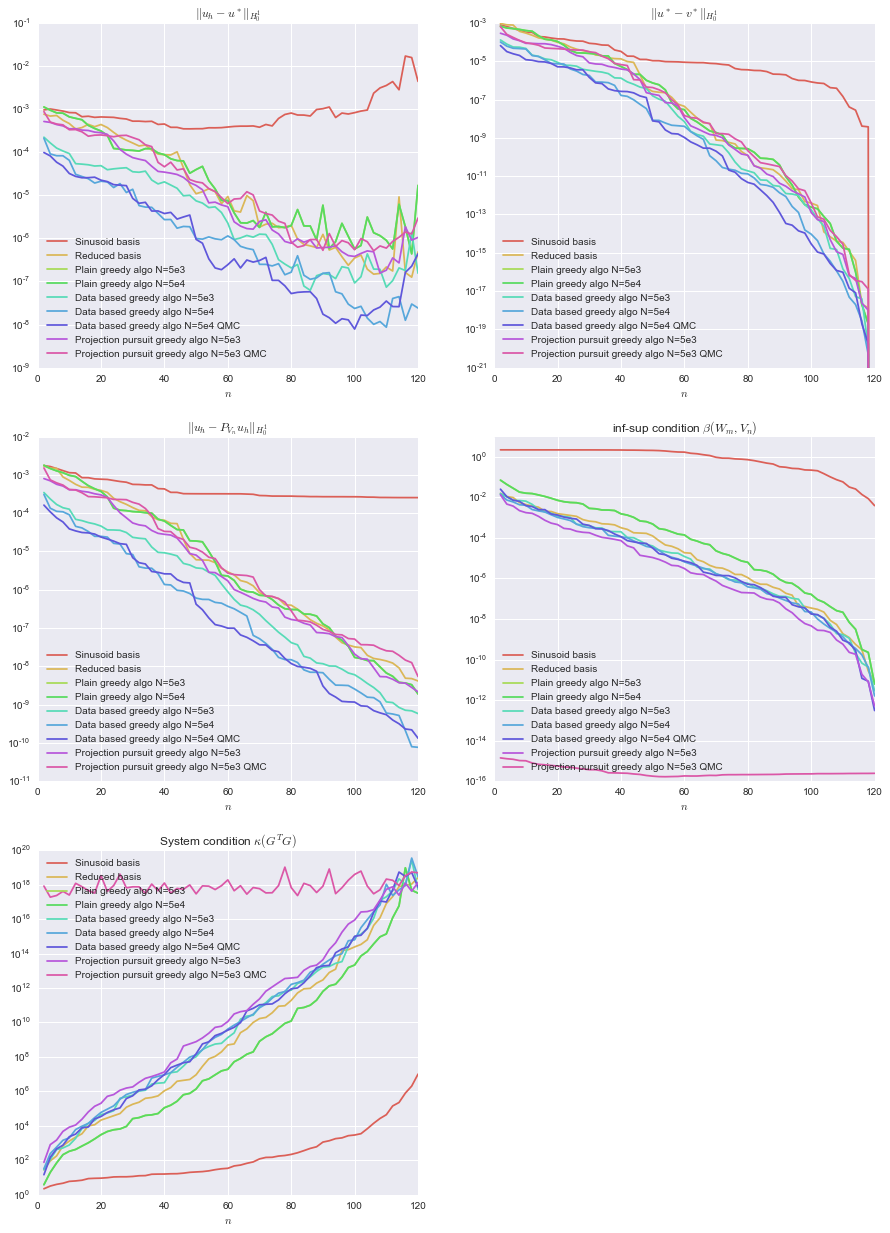

In [17]:

basis_labels = ['Sinusoid basis', 'Reduced basis', 'Plain greedy algo N=5e3', 'Plain greedy algo N=5e4',\
                'Data based greedy algo N=5e3', 'Data based greedy algo N=5e4', \
                'Data based greedy algo N=5e4 QMC', 'Projection pursuit greedy algo N=5e3', \
                'Projection pursuit greedy algo N=5e3 QMC']

sns.set_palette("hls", len(basis_labels))
axs = []
fig = plt.figure(figsize=(15, 21))
axs.append(fig.add_subplot(3, 2, 1, title='$\| u_h - u^* \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 2, title='$\| u^* - v^* \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 3, title='$\| u_h - P_{V_n} u_h \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 4, title=r'inf-sup condition $\beta(W_m, V_n)$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 5, title=r'System condition $\kappa(G^T G)$'))
axs[-1].set(yscale="log", xlabel='$n$')

for j, basis_label in enumerate(basis_labels):

    axs[0].plot(ns, stats[0, j, :], label=basis_label)
    axs[0].legend(loc=3)
    axs[1].plot(ns, stats[1, j, :], label=basis_label)
    axs[1].legend(loc=3)
    axs[2].plot(ns, stats[4, j, :], label=basis_label)
    axs[2].legend(loc=3)
    axs[3].plot(ns, stats[2, j, :], label=basis_label)
    axs[3].legend(loc=3)
    axs[4].plot(ns, stats[3, j, :], label=basis_label)
    axs[4].legend(loc=2)

    
plt.show()

### Ok, it's time to look closer at the selection of elements from the dictionary.

Just how much are we gaining from our optimal selections? Should the parameters for the PDE be different, higher variability? Is it only really the first few elements that are giving us anything? I mean, yes we've got about half an order of magnitude in difference there, which is great and all, but not revolutionary.

Have we got a very very slow improvement in P_Vn as the number N of dictionary elements increase? Is there any help from a better discrepancy of selection points?

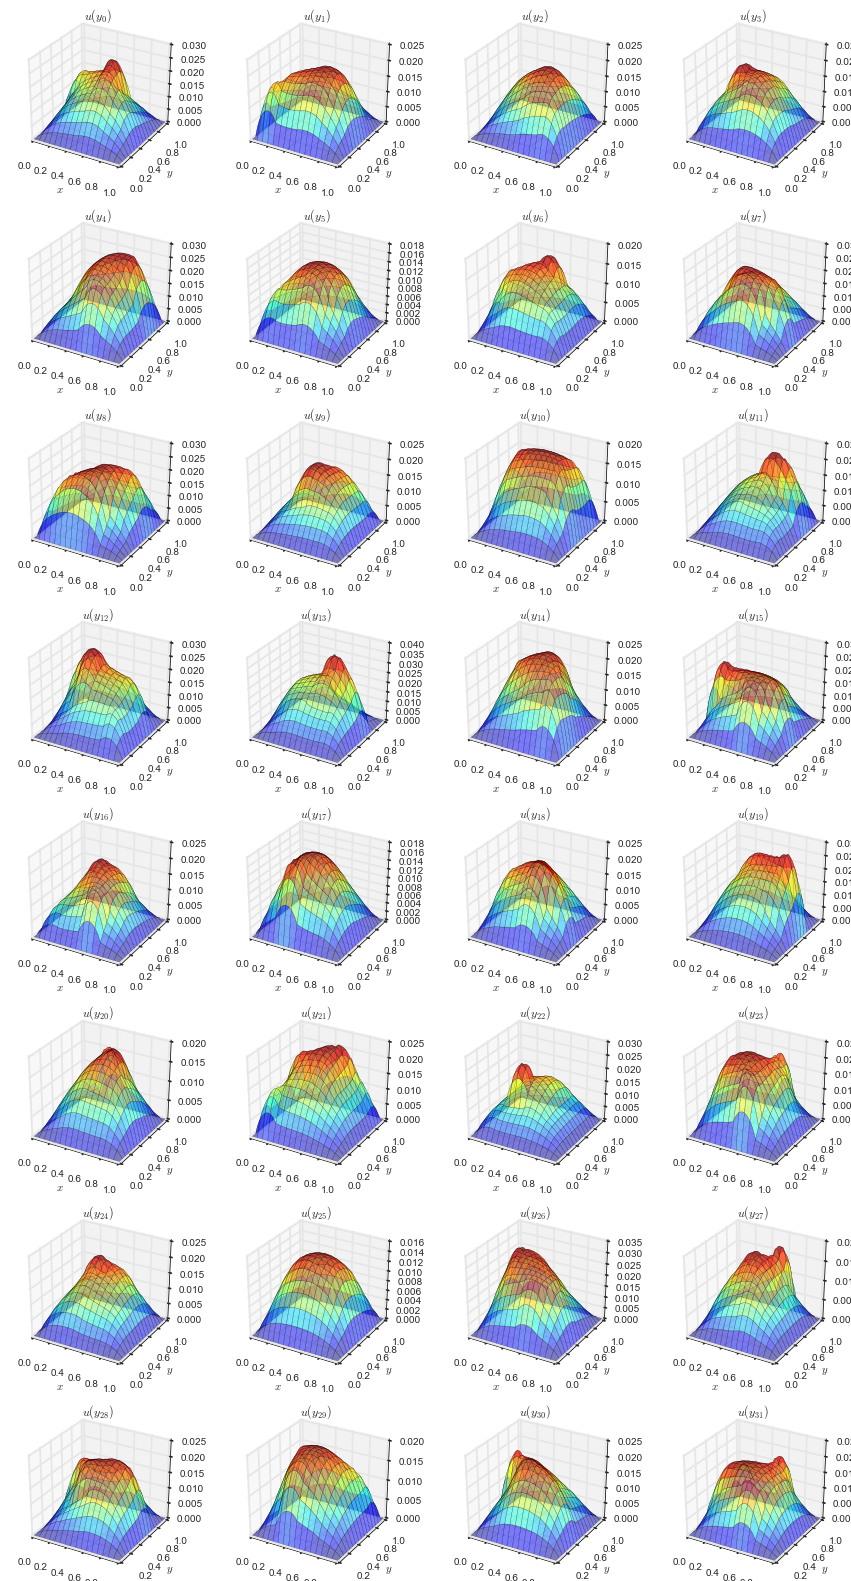

In [4]:
fig = plt.figure(figsize=(15, 28))

for i, u in enumerate(u_dict[:32]):
    
    ax = fig.add_subplot(8, 4, i+1, projection='3d')
    u.plot(ax, title='$u(y_{{{0}}})$'.format(i))

plt.show()


In [ ]:
# Oooh, lets quickly test the save and load functions..